In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.stats import multivariate_normal as mvn
from jax import config


import vsem_jax as vsem
from vsem_inv_prob import (
    InvProb, 
    VSEMPrior, 
    VSEMLikelihood,
    VSEMTest
)

import sys
sys.path.append("./../linear_Gaussian/")
from Gaussian import Gaussian

rng = np.random.default_rng(6435)
config.update("jax_enable_x64", True)


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#
# Exact Inverse Problem
#

n_days = 365 * 2
par_names = ["kext", "av"]

# For exact MCMC
proposal_cov = np.diag([0.3**2, 0.04**2])

likelihood = VSEMLikelihood(rng, n_days, par_names)
prior = VSEMPrior(likelihood.par_names, rng)
inv_prob = InvProb(rng, prior, likelihood, proposal_cov=proposal_cov)

In [ ]:
import jax.numpy as jnp
from gpjax.linalg.utils import add_jitter

gp = vsem_test.gp_posterior
X = vsem_test.design.X
sig2_obs = jnp.square(gp.likelihood.obs_stddev.value)
K = add_jitter(gp.prior.kernel.gram(X).to_dense(), gp.jitter)
Sigma = K + jnp.eye(K.shape[0]) * sig2_obs
L_Sigma = jnp.linalg.cholesky(Sigma, upper=False)


jaxlib.xla_extension.ArrayImpl

In [ ]:
x = train_data.X
y = train_data.y
# Observation noise o²
obs_noise = jnp.square(self.likelihood.obs_stddev.value)
mx = self.prior.mean_function(x)
# Precompute Gram matrix, Kxx, at training inputs, x
Kxx = self.prior.kernel.gram(x)
Kxx = add_jitter(Kxx.to_dense(), self.jitter)

Sigma_dense = Kxx + jnp.eye(Kxx.shape[0]) * obs_noise
Sigma = psd(Dense(Sigma_dense))
L_sigma = lower_cholesky(Sigma)

Kxt = self.prior.kernel.cross_covariance(x, test_inputs)

In [11]:
vsem_test.design.X

Array([[0.246095  , 0.24057791],
       [0.75039572, 0.59704498],
       [0.62461713, 0.39873556],
       [0.63387816, 0.28831429],
       [0.56834061, 0.39263197],
       [0.38181896, 0.73980285],
       [0.96363422, 0.95746462],
       [0.59787009, 0.32589755],
       [0.5008253 , 0.69632974],
       [0.57290999, 0.7276594 ]], dtype=float64)

In [3]:
#
# Surrogate Inverse Problem
#

vsem_test = VSEMTest(inv_prob, n_design=10)

Optimization terminated successfully.
         Current function value: 46.163660
         Iterations: 107
         Function evaluations: 126
         Gradient evaluations: 126


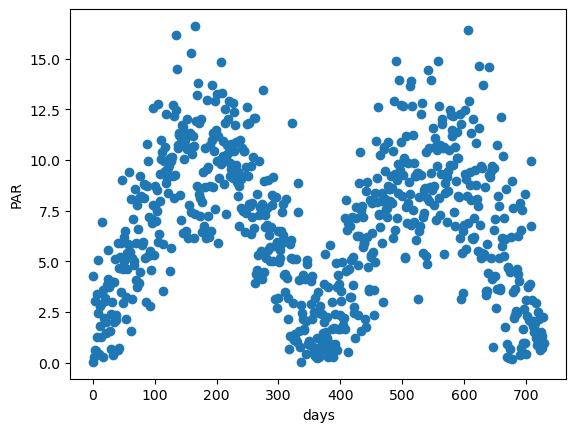

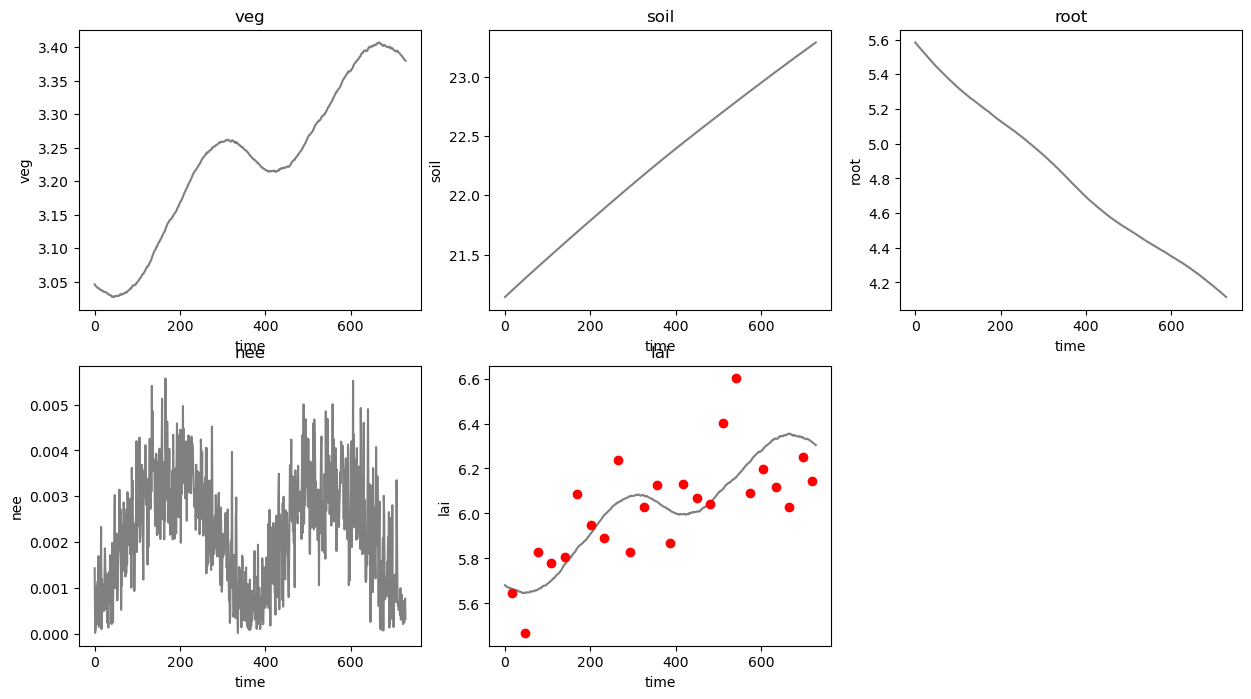

In [4]:
likelihood.plot_driver()
likelihood.plot_ground_truth()

In [ ]:
inv_prob.reset_sampler()
samp, trace_plot = inv_prob.sample_posterior(n_step=10000)

display(trace_plot)

In [ ]:
plt.hist2d(samp[:,0], samp[:,1], bins=30, cmap='Blues')
plt.plot(*likelihood.par_true, "*", color="red", markersize=12)
plt.colorbar(label='Counts per bin')
plt.xlabel('u1')
plt.ylabel('u2')
plt.title('Exact posterior')
plt.show()

In [ ]:
fig_exact, ax_exact = vsem_test.plot_exact_log_post()
fig_gp_post, ax_gp_post = vsem_test.plot_gp_pred(conditional=True, latent_pred=True, figsize=(10,5))
fig_comparison, ax_comparison = vsem_test.plot_true_vs_gp_mean(conditional=True, latent_pred=True, figsize=(10,5))

In [ ]:
fig_comparison.subplots_adjust(bottom=0.3)

display(fig_comparison)